# Семинар 6 - Классические алгоритмы сегментации изображения и обнаружения объектов

**Данный семинар содержит ДЗ**

***

In [17]:
import random as rng

import cv2
import numpy as np
import matplotlib.pyplot as plt

rng.seed(12345)

In [18]:
# !mkdir -p data
# !wget https://github.com/opencv/opencv/raw/4.x/samples/data/cards.png -O data/cards.png

# Image Segmentation with Distance Transform and Watershed Algorithm

Источник - https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html

В этом семинаре вы узнаете, как:

- Использовать `cv2.filter2D`, чтобы выполнить фильтрацию Лапласа для повышения резкости изображения.
- Использовать `cv2.distanceTransform`, чтобы получить производное представление двоичного изображения, где значение каждого пикселя заменяется его расстоянием до ближайшего пикселя фона.
- Использовать `cv2.watershed`, чтобы изолировать объекты на изображении от фона.

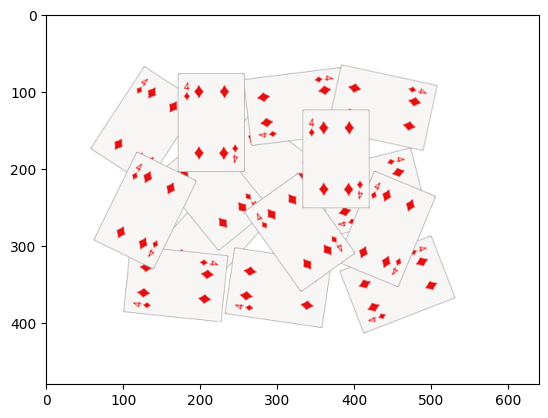

In [19]:
img_src = cv2.cvtColor(cv2.imread("data/cards.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img_src);

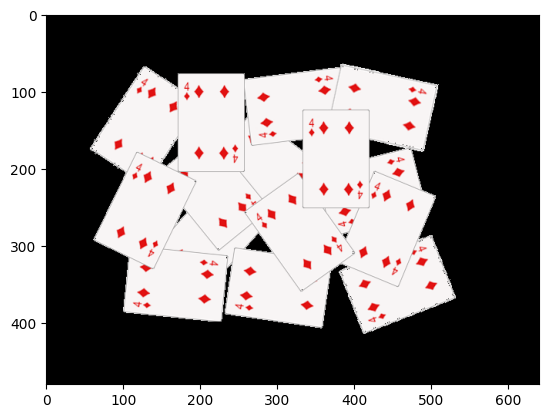

In [20]:
# Change the background from white to black, since that will help later to extract
# better results during the use of Distance Transform
img = img_src.copy()
img[np.all(img == 255, axis=2)] = 0

plt.imshow(img);

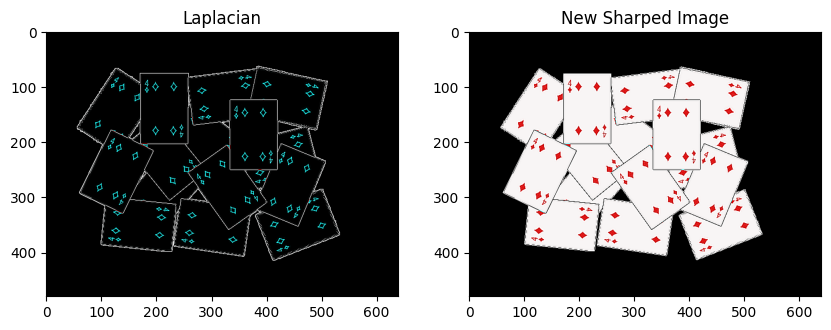

In [21]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array(
    [[  1,  1,  1],
     [  1, -8,  1],
     [  1,  1,  1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
sharp = np.float32(img)
imgResult = sharp - imgLaplacian

# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(imgLaplacian)
plt.title('Laplacian')
plt.subplot(122)
plt.imshow(imgResult)
plt.title('New Sharped Image');

### Бинаризация изображения

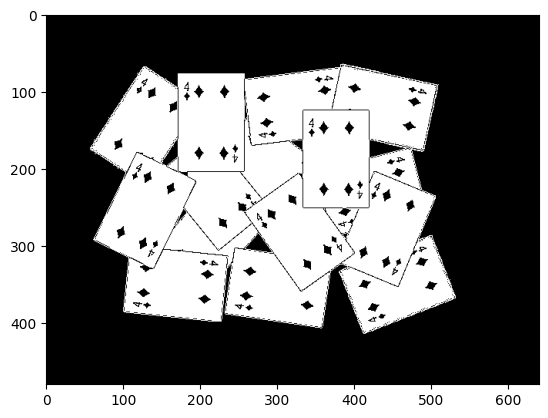

In [22]:
# Create binary image from source image
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw, cmap="Greys_r");

### Distance transform

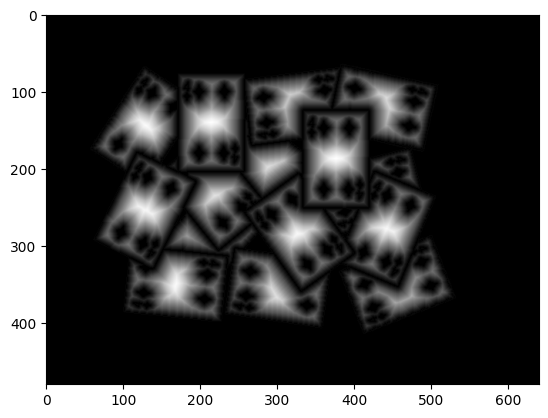

In [23]:
# Perform the distance transform algorithm
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.imshow(dist, cmap="Greys_r");

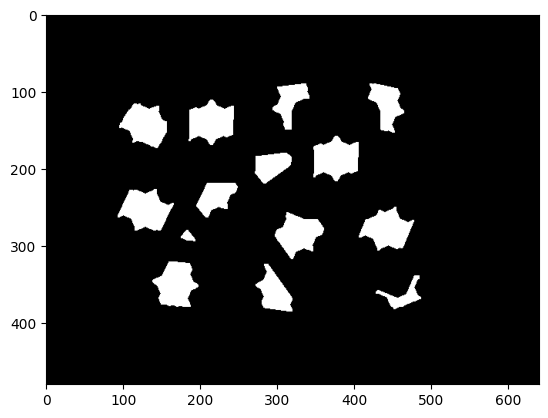

In [24]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.imshow(dist, cmap="Greys_r");

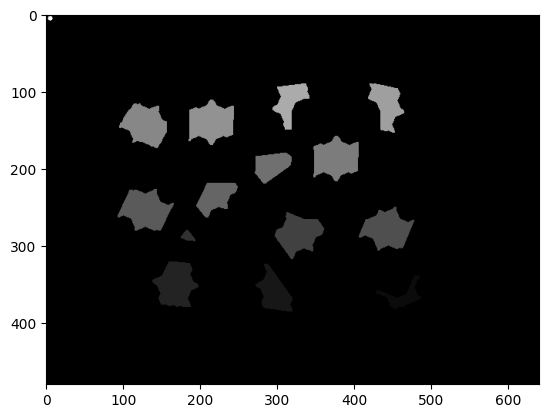

In [25]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(
        markers,   # image
        contours,  # contours list
        i,         # contour index to draw
        (i+1),     # color (fill value)
        -1,        # thickness (if negative - fill the contour)
    )
# Draw the background marker
cv2.circle(
    markers,        # image
    (5,5),          # center
    3,              # radius
    (255,255,255),  # color
    -1,             # thickness (if negative - fill)
)

markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u, cmap="Greys_r");

### Алгоритм Watershed

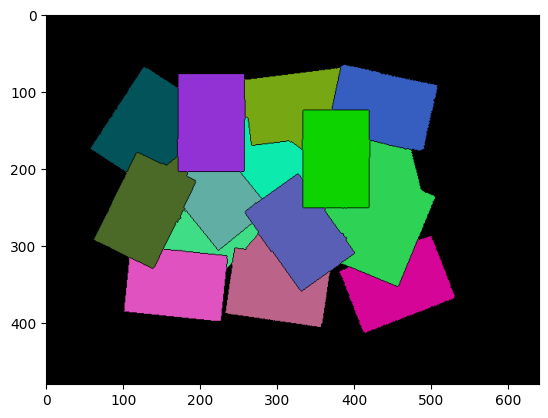

In [26]:
# Perform the watershed algorithm
cv2.watershed(imgResult, markers)

mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
# plt.imshow(mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

# Visualize the final image
plt.imshow(dst);

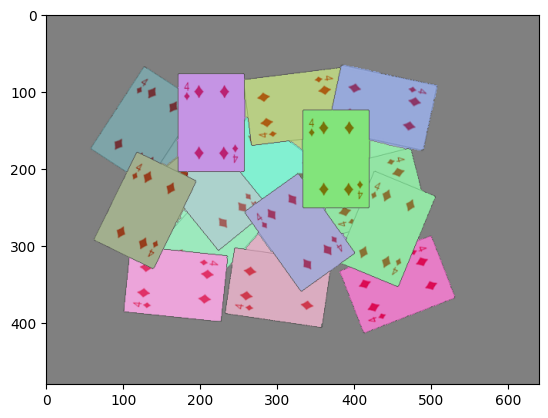

In [27]:
blended = cv2.addWeighted(img_src, 0.5, dst, 0.5, 0.0)
plt.imshow(blended);

# Домашнее задание: подсчет количества пальцев

**Это оцениваемое ДЗ**

Вам предлагается реализовать алгоритм, подсчитывающий количество пальцев.

Один из возможных вариантов решения:
- Получить бинаризованное изображение и найти контур руки;
- Построить выпуклый контур функцией `cv2.convexHull` - https://docs.opencv.org/3.4/d7/d1d/tutorial_hull.html
- Найти дефекты выпуклости контура функцией [`cv2.convexityDefects`](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gada4437098113fd8683c932e0567f47ba)
- После некоторой фильтрации дефектов, их число будет напрямую коррелировать с числом пальцев.

**Требования:**
1. Продемонстрируйте работоспособность алгоритма на любом числе пальцев (от 0 до 5).
2. Используйте фото своей руки для демонстрации (предложенное фото лишь для отладки).

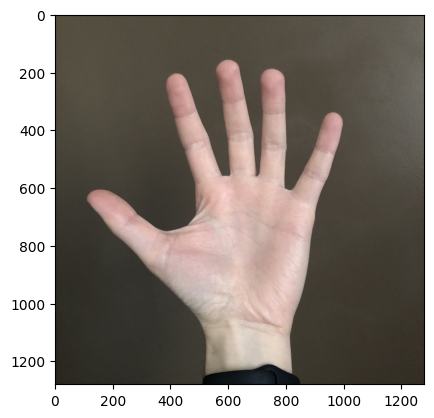

In [48]:
img = cv2.cvtColor(cv2.imread("data/hand.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [60]:
def count_fingers(img):
    kernel = np.array(
        [[  1,  1,  1],
        [  1, -8,  1],
        [  1,  1,  1]], dtype=np.float32)

    imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
    sharp = np.float32(img)
    imgResult = sharp - imgLaplacian

    imgResult = np.clip(imgResult, 0, 255)
    imgResult = imgResult.astype('uint8')

    binary = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(binary, 80, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    max_contour = max(contours, key=cv2.contourArea)

    hull = cv2.convexHull(max_contour, returnPoints=False)
    
    try:
        defects = cv2.convexityDefects(max_contour, hull)
    except cv2.error:
        plt.imshow(img)
        plt.title('Detect fingers')
        plt.axis('off')
        plt.show()
        return 0

    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(max_contour[s][0])
        end = tuple(max_contour[e][0])
        far = tuple(max_contour[f][0])
        cv2.line(img, start, end, (0, 255, 0), 2)
        cv2.circle(img, far, 5, (0, 0, 255), -1)

    plt.imshow(img)
    plt.title('Detect fingers')
    plt.axis('off')
    plt.show()

    finger_count = 0
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(max_contour[s][0])
        end = tuple(max_contour[e][0])
        far = tuple(max_contour[f][0])

        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)) * 180 / np.pi

        if angle < 90 and d > 20000:
            finger_count += 1

    return finger_count+1

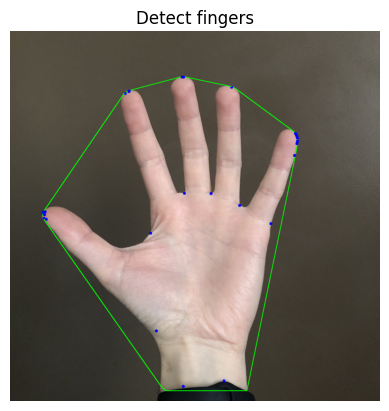

Количество пальце по мнению алгоритма = 5


In [61]:
img = cv2.cvtColor(cv2.imread("data/hand.jpg"), cv2.COLOR_BGR2RGB)
print(f"Количество пальце по мнению алгоритма = {count_fingers(img)}")

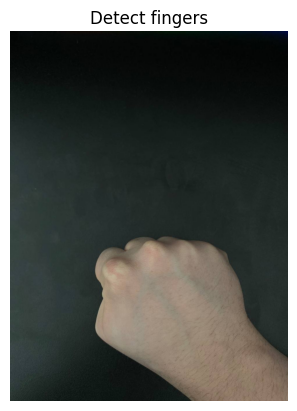

Количество пальце по мнению алгоритма = 0


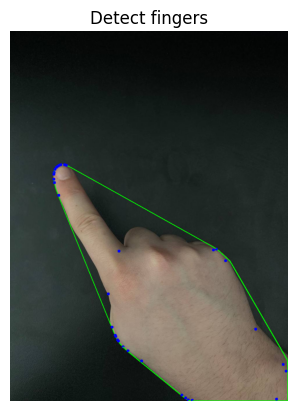

Количество пальце по мнению алгоритма = 1


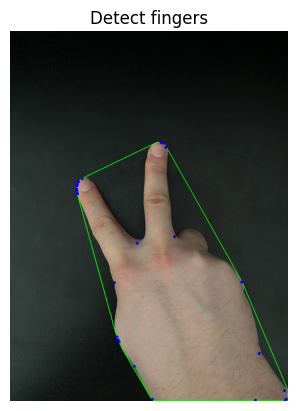

Количество пальце по мнению алгоритма = 2


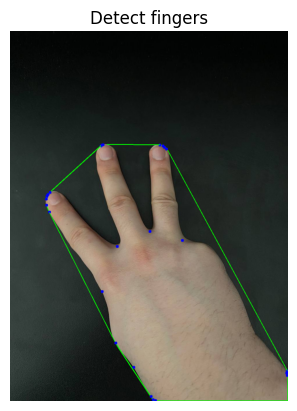

Количество пальце по мнению алгоритма = 3


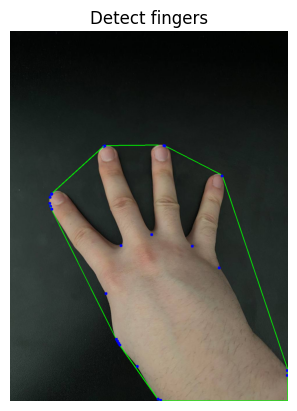

Количество пальце по мнению алгоритма = 4


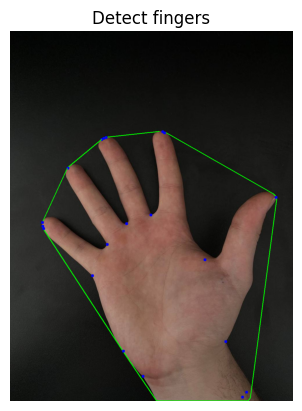

Количество пальце по мнению алгоритма = 5


In [ ]:
for i in range(6):
    img = cv2.cvtColor(cv2.imread("data/my_hand_" + str(i)+".jpg"), cv2.COLOR_BGR2RGB)
    print(f"Количество пальцев по мнению алгоритма = {count_fingers(img)}")